# Data Generation
Script generating spectral density functions with different levels of noise


In [1]:
import numpy as np
from numpy.random import uniform, random
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from helpers import Peak
import pickle

In [2]:
U_max = 5
dw = 0.1

def integral(f):
    return np.sum(dw * f)

Nw = int(U_max / dw)
ws = np.linspace(0, U_max, Nw + 1)
ws

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

{'U': 4.886711354454222, 'peaks': [Peak(center=2.443355677227111, height=0.20448096464522114, width=1.102188799878954, shape='quadratic')]}


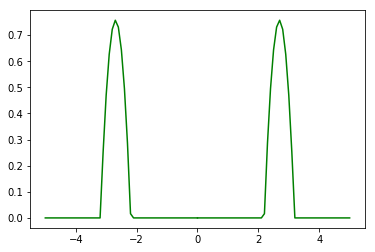

In [3]:
def generate_spectral_density(ws, U_max, seed=None):
    """ Returns an array of A[i] containing the values of A at ws[i] """
    if seed is not None:
        np.random.seed(seed)
    peaks = []
    # Interaction strength
    U = uniform(0, U_max)
    # Metallic or insulator
    metallic = random() < (U_max - U) / U_max
    if metallic:
        peaks.append(Peak(
            0,
            0.5,
            min(2, 4 / U**2),
            'quadratic'
        ))
    # Generating first peak
    peaks.append(Peak(
        U / 2,
        uniform(0.1, 0.4),
        uniform(0.5, 2),
        'quadratic'
    ))
    # Aggregate all the peaks
    return aggregate(ws, peaks), {
        'U': U,
        'peaks': peaks
    }

def aggregate(ws, peaks):
    values = np.max([peak.evaluate(ws) for peak in peaks], axis=0)
    # Normalize (ToDo: investigate as it can make us go below 1/2)
    return values / integral(values) / 2 # since we only focus on w >= 0)

A, params = generate_spectral_density(ws, U_max)
print(params)
plt.plot(ws, A, 'g')
plt.plot(-ws, A, 'g')

In [4]:
def compute_green(A, ws, n):
    """ Computes Integral(A(w) / (iw_n - w)) for a given n"""
    return complex(integral(A / (1j * (2 * n + 1) - ws)))

print(compute_green(A, ws, 0))

(-0.16364523132369857-0.061485218052587484j)


In [5]:
def compute_greens(A, ws, nw_cutoff=300):
    """ Computes Integral(A(w) / (iw_n - w)) for all n below nw_cutoff"""
    ReG, ImG = [], []
    for n in range(nw_cutoff):
        z = compute_green(A, ws, n)
        ReG.append(z.real)
        ImG.append(z.imag)
    return ReG + ImG

compute_greens(A, ws, nw_cutoff=5)

[-0.16364523132369857,
 -0.08254985639219051,
 -0.04162002167814666,
 -0.02388760513325707,
 -0.015236422435710651,
 -0.061485218052587484,
 -0.09250004302833932,
 -0.07749822911753201,
 -0.06219204920070672,
 -0.05097052443396978]

## Full generation of data

In [6]:
# ToDo: If model finds data back successfully => add noise !!

In [7]:
N_samples = 10

In [8]:
np.random.seed(42)  # for reproductibility
results = []
for _ in trange(N_samples):
    A, params = generate_spectral_density(ws, U_max)
    results.append({
        'params': params,
        'greens': compute_greens(A, ws)
    })

In [9]:
with open('data.pkl', 'wb+') as out:
    pickle.dump(results, out)